<!-- dom:TITLE: Machine Learning Methods for Events Classification in the AT-TPC -->
<!-- dom:AUTHOR: Author: Ceulemans Andreas, Fracassetti Stefano, Youssef Ahmed, Haoran Sun -->
<!-- Author: -->  

# <p style="text-align: center;"><span style="color:darkred">Machine Learning Methods for Events Classification in AT-TPC</span> 

**Authors:** Fracassetti Stefano $^1$, Ceulemans Andreas $^1$, Youssef Ahmed $^1$, Morselli Luca $^2$, Sun Haoran$^3$ 

**$^1$** KU Leuven University, Belgium   
**$^2$** -     
**$^3$** -    

**Date:** August 31, 2020 


**Aknowledments:**   
A special thanks to the professor of the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a> for the course offered in Machine Learning.    
The course was given by the <a href="http://fribtheoryalliance.org/TALENT/">TALENT Initiative</a>, at <a href="https://www.ectstar.eu/">ECT* in Trento</a>.

    
**Credits:** 
- Fracassetti Stefano:
- Ceulemans Andreas:
- Youssef Ahmed:
- Morselli Luca:
- Sun Haoran:

# <span style="color:darkred">Description of the Project</span> 
(for better rendering, open the report locally with Jupyter Notebook, GitHub does not offer the best visualization)

## Task
The main objective of this project is to classify events (simulated data) aquired from the Active Target AT-TPC, as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save on disk for future analysis. The project task is described in the <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">Project Specifications</a>.

We will apply the ML techiques learned during the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a> , in order to analyse the data and reach the best performance possible.<br>


## Tabel of Content:

#### Data Import
In this section we deal with the data import, and we perform the first basic operations on the data.
- Data Import: from HDF5 format into python
- Data Storage: nested List
- Labelling of the data (supervised learning): beam or Reaction?
- Cleaning of the data: remove all empty events.
- Data Slitting: Train, Validation, and Test through Scikit-learn

#### Data Exploration
In this section we will visualize the data, to get a first insight on the data we are analysing. We then extract event features that we consider meaningful for classification task, and we visualize them as well.
 
- Data Visualization: 3D plot, and 2D Pad Plane projections.
- Event Features: calculating event features to be used for classification
- Visualizing the Features (and the Outliers)
- Scaling the Data

#### Machine Learning
In this section we propose various approaches to tackle to problem, and we show the results obtained with each methods.

Most simple approaches:
- Logistic Regression  
- Random Forest (with Grid Search)    
- Dense Neural Networks DNN
- K-Means (varying cluster number)    
- Support Vector Machine SVM


- Convolutional Neural Network
    - Generating Images
    - CNN with a costumized model, and the VGG16
    
    
- Dimensionality Reduction Algorithms
    - 
    -
    -
    

### Common Import

In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K


from helper_functions import *

# Aliases
layers = tf.keras.layers
# Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# <span style="color:darkred">Data Import</span> 

### Data Format
Data are saved in <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">DataFiles/Mg22_alphaalpha_digiSim.h5</a>, which contains 2000 simulated events: even numbers are "beam" events, while odd numbers are "reaction" event. Each event is constitued by a point cloud of the active pads for that event. The number of hit pads may vary for each event, ranging from around 20, up to a few hundred.  

Each hit pad is associated with a 4-tuple (x, y, z, t, A): 
- (x,y) are the position of the hit pad on the detector plane, 
- z is the coordinare associated to the beam axis,
- t is the time associated with the pad signal, and
- A is the charge deposited on the pad.<br> 

The time information is unnecessary since data already contains the z coordinate thanks to a pre-processing phase. There is also an extra column of zeros, which do not carry any meaningful information.<br>


### Let's have a look at the data file 

#### <p style="text-align: center;"> HDF5 file Format
First we load the data, which are stored as a hdf5 file, a (Hierarchical Data File) format designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:
- Datasets: multidimensional arrays of a homogenous type
- Groups: container structures, that can hold Datasets or other groups

What's important to remember is that when opening a HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating this file objecct in which "Groups work like Dictionaries, and DataSets work like NumPy arrays", it is possible to check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

#### <p style="text-align: center;"> Mg22_alphaalpha_digiSim.h5
In this file, there were no groups, but 2000 datasets each one corresponding to an event, named "Event_[#]". Each event/key is a 2D-array which contains 6 columns and multiple rows (hit pads).

- We first want to give a table view of the data by printing the first event as example:<br>
```
pd.DataFrame(hf.["Event_[i]"])
```

- We then want to visualise the lenght of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few events type to see how many pads were written per event:<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
We can see now that the keys have the name "Event_[#]", we can see the shape of the event.
It is possible to notice that the reaction event have consistently more hit pads in respect to the beam events.
<br/><br/>
- Eventually we will plot the entire set of information for an event to see the actual structre:<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```

### Loading the Data
We will first load the datafile, and visualize the first event: Event_[0] 

In [10]:
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')


#Table view of an event
Event_0=pd.DataFrame(hf["Event_[0]"][:])
print("DataSet: Mg22_alphaalpha_digiSim.h5")
print("Event Number: 0")
print("Label: Beam")
display(Event_0)

DataSet: Mg22_alphaalpha_digiSim.h5
Event Number: 0
Label: Beam


,x,y,z,t,A,trackID
0,-2.454130,1.450752,834.0,417,6733.605773,0
1,-0.000013,2.799905,834.0,417,12585.463255,0
2,-2.454130,-1.450752,834.0,417,1705.208085,0
3,2.454133,-1.450752,900.0,450,3778.845219,0
4,-0.000013,-2.799905,900.0,450,11368.678344,0
5,2.454133,1.450752,962.0,481,3210.764796,0
6,4.908251,-5.701409,964.0,482,44.570651,0
7,2.454104,7.050561,966.0,483,21.112801,0
8,-2.454131,-7.050561,984.0,492,19.055387,0
9,-4.908247,5.701409,986.0,493,19.747327,0


### Data Storage

#### <p style="text-align: center;"> Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event. Each dataset have different lenght, and lists are able to handle this without problem.
In the next cell, we import the data in a list.
We can show each element of a list, which correspond to a single event of the hdf5 file.  
    
We could check that these two operations give the same result:
```
    print(hf["Event_[0]"][:])
    print(DataList[0])
```

    
#### <p style="text-align: center;"> Pandas DataFrame/Series, Numpy Array ?
These structure do not seem to respond nicely to our needs. 
    
- **Pandas DataFrame** are 2D structure of fixed lenght. In our case, we would need 3D array, where one variable has a variable lenght. Providing that we could stored NaN (or predefined value) where data is missing, there is still the proble we can not store all the DataSet in a DataFrame structure type. However it is possible to store each event in a single and different DataFrace structure. There is no advantage to do this in respect to a list in the end, so we still opt on nested list.<br/><br/>
    
- **Pandas Series** are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. Not adapted for our data.<br/><br/>   
    
- **Numpy Array** are a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. This structure is not adapt to host our data, since they required again a fixed dimension. In principle it would be possible leaving (or predefined value) where data are missing. This method is inefficient. As for DataFrame, it would be possible to use this struture to store each event in a single and different Numpy Array.

Anyway, one has different possibilities after extracting the relevant features, from the 2D matrix. It is possible in that case to use Numpy Array, or DataFrame, or Lists again. 

### Labeling and cleaning

#### <p style="text-align: center;"> Labeling

The next step is to label and clean the data.
We know from the task description that the data come labeled (supervised learnig):
- Reacion Event (Label=1)
- Beam Event (Label=0)  
    
Note that assigning 1 or 0 is a matter of choice, it is possible to do the opposite.
This choice reflect the idea that a reaction event is to keep, while a beam event must be rejected, so associated to a nul value.

#### <p style="text-align: center;"> Cleaning
   
This phase is rather simple, the events do no have missing values. We only noticed that we deal with "empty" events. Event number (384, 430,484,914,1204 (numbers correspond to keys)) do not contain any value, so must be discarded.
    
    
All the operation mention above are perfromed through the function load_data, defined in helper_functions.py

In [11]:
DataList, Labels = load_data(hf)
hf.close()

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



The DataSet we are going to analyse is formed by 1995 non-empty events. The histgram below shows length of the remaining non-empty events.

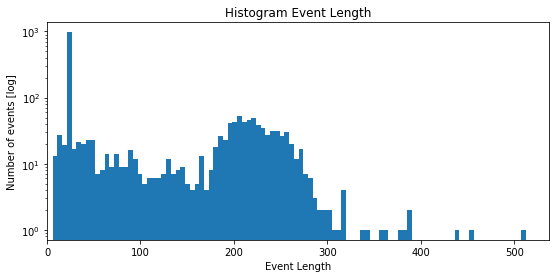

In [12]:
EventLength = []
#Histgram for the distribution of the length of events
for i in range(len(DataList)):
    EventLength.append(len(DataList[i]))
EventLength = np.asarray(EventLength)

# Plot length distribution
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(EventLength, bins = 100)
ax.set_title('Histogram Event Length')
ax.set_xlabel("Event Length")
ax.set_xlim(0,)
ax.set_yscale('log')
ax.set_ylabel("Number of events [log]")
plt.show()

### Slpitting the data

####  <p style="text-align: center;"> Training - Validation - Testing
In every ML algorithm we have to first split the data in training, validation and (possibly) test. 
- **Training Data** will be used to feed the algorithm and to train it. 
    
    
- **Validation Data** are going to be used in order to see how our algorithm performs on data which has not be used to train it.<br/> Anyway, validation data would be useful to tune our algorithm, e.g. deciding when to stop the training, and adjust some parameters.
    
    
- **Test Data** are meant to test the algorithm on completely newly data, such as they were a different dataset.
    
Usually the original data are divided for 90% - 70% into training and the rest for validation and testing.
    
Sklearn provides a function: "train_test_split" which makes this operation very handy. This function would split the data in two subsets, in a fraction which is possible to specify through the function options. Applying twice this function we can reach our goal. 
    
In order to save memory and computation time (because we care about our computers), we do not load the function with actually features and labels, as more obvious choice, but simply with a list of index, which would result in the creation of indexes subsets, wich can be used to separate the data.   
The outcome of this operation can be viewed as shuffling the indexes in three subsets, of desider lenght.

In [13]:
x_idx = np.arange(len(DataList))


# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)


print("Dataset was slitted in train, validation, and test:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was slitted in train, validation, and test:
1615 training events,
180  validation events, and
200  test events


# <span style="color:darkred">Data Exploration</span> 

### Visualizing the data: let's get some insight!
Now that the data have been prepared, we would like to have a first look at the data.  
We plot the first 12 events:
- 3D plots (x,y,z)
- 2D projections (x,y) - the event as seen from the plane surface.

### 3D Visualization (x, y, z)

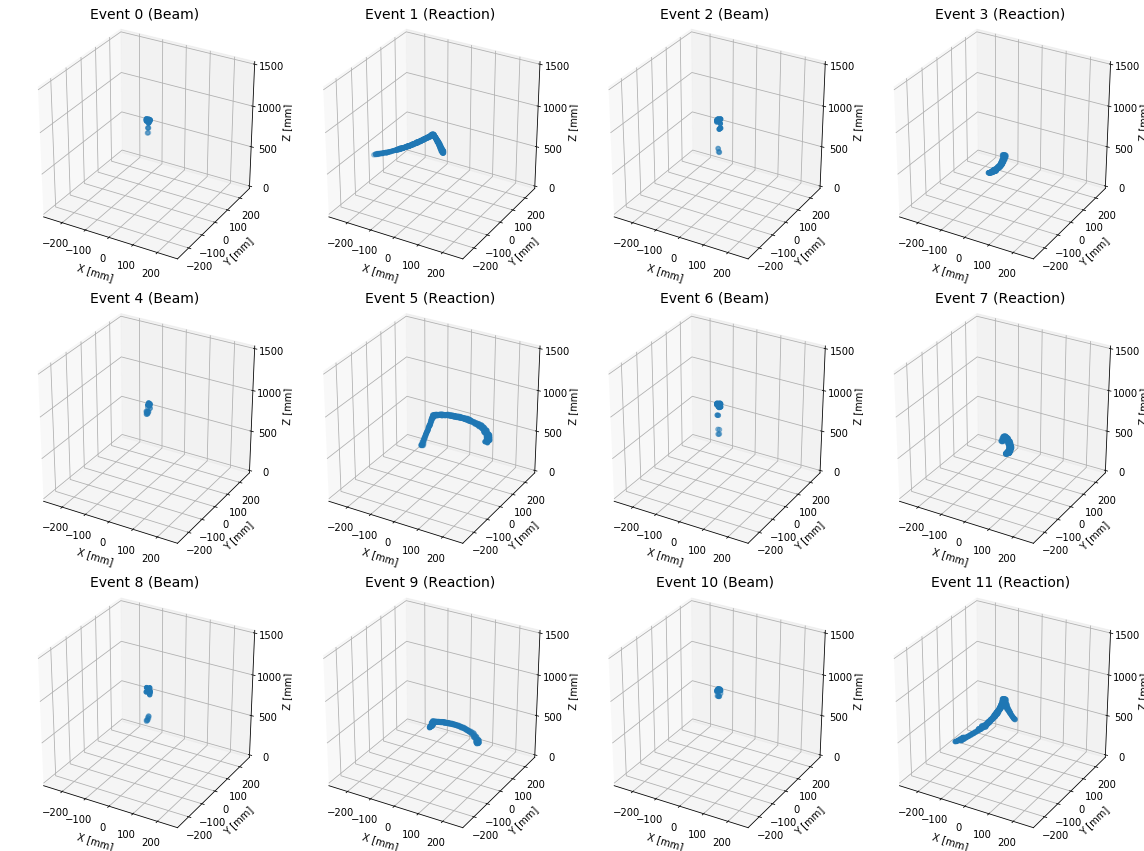

In [14]:
plot_3d_events(DataList,Labels)

### Pad Plane Projections (x, y)
For this events the gray scale correspond to the charge deposited on the respctive pad (in a logarithmic scale).

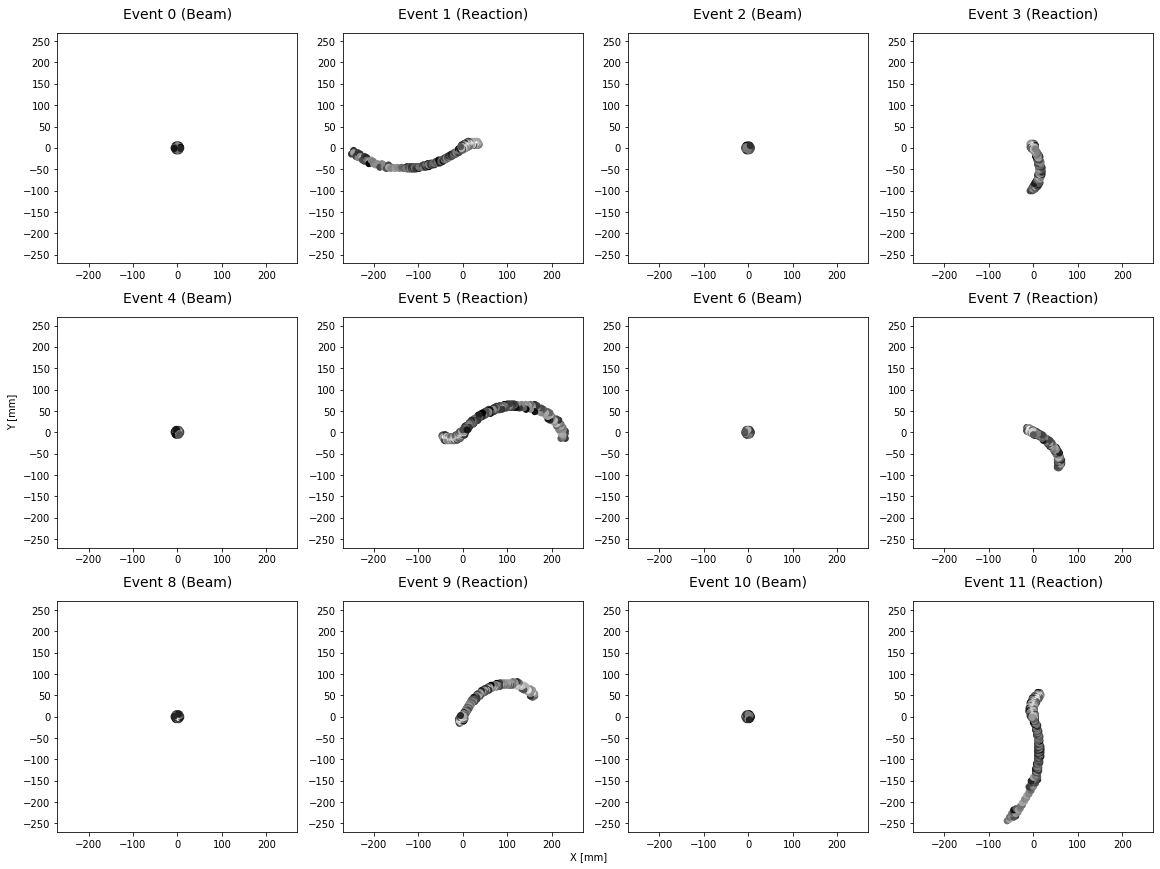

In [15]:
plot_2d_events(DataList, Labels)

###  Selecting Features
After plotting the data (two previous cells), it is quite clear that the number of pads plays a crucial role, but not only that. By eyes we can somehow differentiatig the events to be labelled as "beam" since they present a more definite (and almost straight?) track.
We thought some relevant characteristics could be the average value of x,y and z, or rather a weighted avereage, based on the charge deposited. Also, the total deposited charge can be an interesting quantity. 

Here a list of the quantity we calculated:
```
# Every quantity is computed for each single event

MeanXPerEvent         # Average X value 
MeanYPerEvent         # Average Y value 
MeanZPerEvent         # Average Z value

MeanWeightedXPerEvent # Charge weighted average X 
MeanWeightedYPerEvent # Charge weighted average Y
MeanWeightedZPerEvent # Charge weighted average Z

StDevXPerEvent        # Standard deviation of X 
StDevYPerEvent        # Standard deviation of Y
StDevZPerEvent        # Standard deviation of Z

SumAPerEvent          # Total deposited charge
PadsPerEvent          # Number of pads fired
FracClosePtsPerEvent  # Fraction of pads inside a cylinder of radius 10cm to the z-axis
```


#### <p style="text-align: center;"> Selecting only relevant characteristics
    
Which data do we feed into the algorithm? We cannot feed all the 2D martix containing all the information for each event, we need to see a design matrix, and select relevant features for each events. Furthermore, a non-fixed lenght of the 2D matrix would create additonal challenges in how to manage those data.

So, we need to extract a number of relevant features for each event, based on the information available for that event. Whtich characteristcs would help us differentiating events based on the fact that we are dealing with a "beam" rather than a "reaction" label? 

The question can be answered having a look to different events, previously we noticed e.g. that the beam events tend to have a much larger number of hit pads respect to reation events. Other features are not obvious, and need a bit of analysis.
    
Let's get some insights of the features we can use! And to do this let's first have a look to the events, plotting in a 3D graph. We do this using the function "plot_3d_event", previously defined in the other file.
    

In [16]:
# Computing Features
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)


### Visualizing the Features 
In order to visualize the features extracted, and whether are well suited for our goal, we will show in the plots below the results obtained. Some of the extracted features will be more relevant, such as the number of hit pads, the total charge deoposited, and the mean Z , while others, like mean x or mean y are not so interesting. 

In [17]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

Histograms:


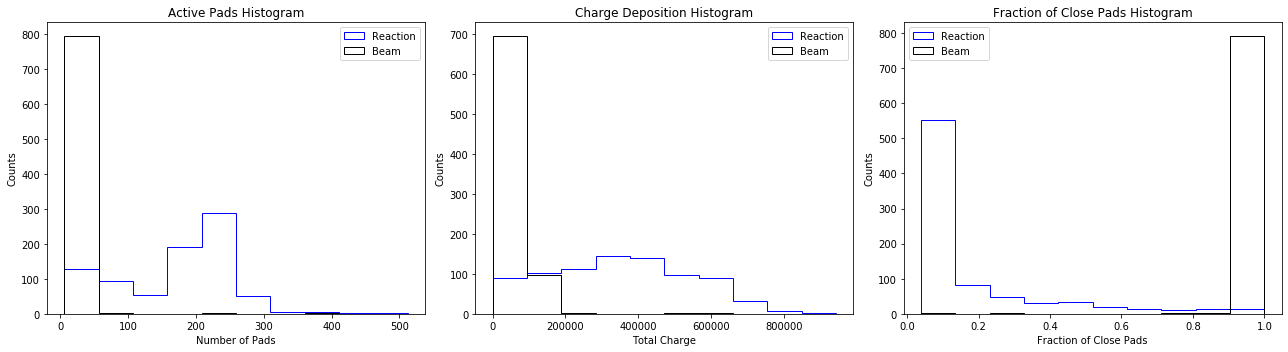

In [18]:
print("Histograms:")
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

#Histograms 


#mannualy set number of bins for both two histgrams and make the bin widths equal to each other

bins1=np.histogram(np.hstack((PadsPerEvent[Labels>0.5],PadsPerEvent[Labels<0.5])), bins=10)[1]

bins2=np.histogram(np.hstack((SumAPerEvent[Labels>0.5],SumAPerEvent[Labels<0.5])), bins=10)[1]

bins3=np.histogram(np.hstack((FracClosePtsPerEvent[Labels>0.5],FracClosePtsPerEvent[Labels<0.5])), bins=10)[1]

ax[0].hist(PadsPerEvent[train_r_idx],bins=bins1, color = r_color, label = 'Reaction', histtype = 'step')
ax[0].hist(PadsPerEvent[train_b_idx],bins=bins1, color = b_color, label = 'Beam', histtype = 'step')
ax[0].set_title("Active Pads Histogram")
ax[0].set_xlabel("Number of Pads")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].hist(SumAPerEvent[train_r_idx],bins=bins2, color = r_color, label = 'Reaction', histtype = 'step')
ax[1].hist(SumAPerEvent[train_b_idx],bins=bins2, color = b_color, label = 'Beam', histtype = 'step')
ax[1].set_title("Charge Deposition Histogram")
ax[1].set_xlabel("Total Charge")
ax[1].set_ylabel("Counts")
ax[1].legend()

ax[2].hist(FracClosePtsPerEvent[train_r_idx],bins=bins3, color = r_color, label = 'Reaction', histtype = 'step')
ax[2].hist(FracClosePtsPerEvent[train_b_idx],bins=bins3,color = b_color, label = 'Beam', histtype = 'step')
ax[2].set_title("Fraction of Close Pads Histogram")
ax[2].set_xlabel("Fraction of Close Pads")
ax[2].set_ylabel("Counts")
ax[2].legend(loc='upper left')

fig.tight_layout() # adjust automatically spacing between sublots
plt.show()

TO BE COMPLETED
- *Active Pads and Charge Deposition Histogram*, it is clear that the reaction events tend to have a lower amount of active pads, as well a much higher charge deposited. This variables alone can already separate the two type of event quite well. The reason is that beam events comes at high energy, and leave an intense track, while reaction scattering transfer lower energy to its components.
- *Fraction of Close Pads*, this variable represents the fraction of active pads confined in a radius of 10cm, in relation to all the pads fired for that event. It is possible to notice that for the reaction events this variable is close to 1. Beam events have a higher dispension in the three x,y (and z) directions (see also stdev plots).

Scatter Plots: X, Y, Z


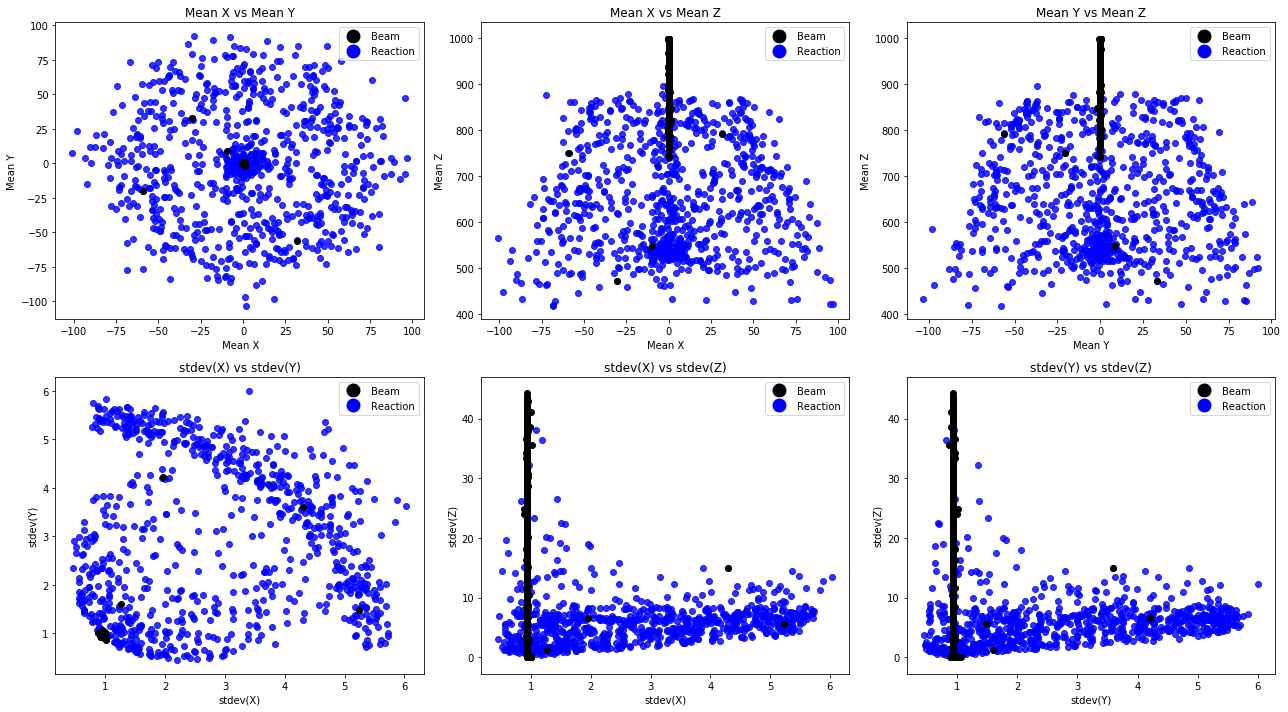

In [19]:
print("Scatter Plots: X, Y, Z")
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Mean values
ax[0][0].scatter(MeanXPerEvent[train_r_idx],MeanYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][0].scatter(MeanXPerEvent[train_b_idx],MeanYPerEvent[train_b_idx], c = b_color)
ax[0][0].set_title("Mean X vs Mean Y")
ax[0][0].set_xlabel(" Mean X")
ax[0][0].set_ylabel("Mean Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color,  alpha=0.8)
ax[0][1].scatter(MeanXPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][1].set_title("Mean X vs Mean Z")
ax[0][1].set_xlabel("Mean X")
ax[0][1].set_ylabel("Mean Z")
ax[0][1].legend(handles=legend_elements)

ax[0][2].scatter(MeanYPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][2].scatter(MeanYPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][2].set_title("Mean Y vs Mean Z")
ax[0][2].set_xlabel("Mean Y")
ax[0][2].set_ylabel("Mean Z")
ax[0][2].legend(handles=legend_elements)

# Standard Deviations
ax[1][0].scatter(StDevXPerEvent[train_r_idx],StDevYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][0].scatter(StDevXPerEvent[train_b_idx],StDevYPerEvent[train_b_idx], c = b_color)
ax[1][0].set_title("stdev(X) vs stdev(Y)")
ax[1][0].set_xlabel("stdev(X)")
ax[1][0].set_ylabel("stdev(Y)")
ax[1][0].legend(handles=legend_elements)

ax[1][1].scatter(StDevXPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][1].scatter(StDevXPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][1].set_title("stdev(X) vs stdev(Z)")
ax[1][1].set_xlabel("stdev(X)")
ax[1][1].set_ylabel("stdev(Z)")
ax[1][1].legend(handles=legend_elements)

ax[1][2].scatter(StDevYPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][2].scatter(StDevYPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][2].set_title("stdev(Y) vs stdev(Z)")
ax[1][2].set_xlabel("stdev(Y)")
ax[1][2].set_ylabel("stdev(Z)")
ax[1][2].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

TO BE COMPLETED
- *Mean X,Y,Z*, from (X,Y) plot we can notice that reaction evetns tend to lay in the conter of the plot, while beam events are scattered with a certain dispersion. Plots (X,Z) and (Y,Z) are more interesting, since we can notice how rection events have generally an higher mean Z. 
- stdev X,Y,Z, beam events have generally a larger spread in X and Y direction, reaction events the opposite:  higher z dispersion, but much smaller stdev in x and y. 

Scatter Plots: Other Combinations


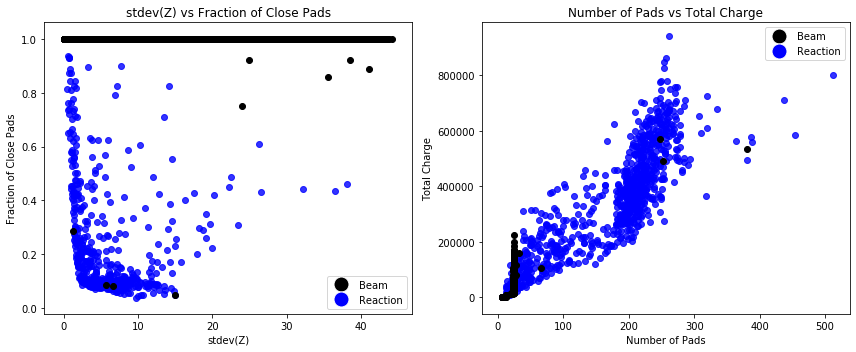

In [20]:
print("Scatter Plots: Other Combinations")
fig, ax = plt.subplots(1,2, figsize=(12, 5))

ax[0].scatter(StDevZPerEvent[train_r_idx],FracClosePtsPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0].scatter(StDevZPerEvent[train_b_idx],FracClosePtsPerEvent[train_b_idx], c = b_color)
ax[0].set_title("stdev(Z) vs Fraction of Close Pads")
ax[0].set_xlabel("stdev(Z)")
ax[0].set_ylabel("Fraction of Close Pads")
ax[0].legend(handles=legend_elements)

ax[1].scatter(PadsPerEvent[train_r_idx],SumAPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1].scatter(PadsPerEvent[train_b_idx],SumAPerEvent[train_b_idx], c = b_color)
ax[1].set_title("Number of Pads vs Total Charge")
ax[1].set_xlabel("Number of Pads")
ax[1].set_ylabel("Total Charge")
ax[1].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

TO BE COMPLETED
- FCP and stdev(z), 
- Total Charge and #pads, Reaction evetns are localized in the region of low amount of active pads, and low charge. Beam event are spread all around the region, with a positive correlation between the two variable.

### Visualizing the Outliers
In the plots above there are some outliers: events which label may be mistaken, when looking to the features extracted. We want to plot this events, and see how they look like.

These outliers are beam events, which look really like reaction events.

Outliers using different criteria:
stdev(X) > 3 cm       : [ 499 1711]
Number of Pads > 100  : [ 368  499 1711]
FCP < 0.4             : [ 368  499 1237 1711]
Outliers that satisfy at least one criterion: [ 368  499 1237 1711]


>>> Outliers:  368
stdev(X)       :  1.9582723372304964
Number of Pads :  253.0
FCP            :  8.30%


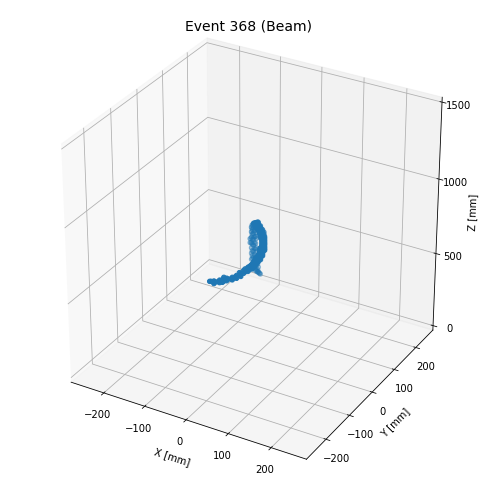

>>> Outliers:  499
stdev(X)       :  4.298400846348025
Number of Pads :  380.0
FCP            :  5.00%


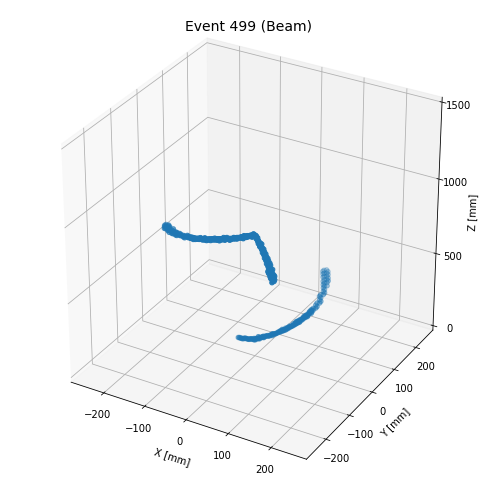

>>> Outliers:  1237
stdev(X)       :  1.258991666148929
Number of Pads :  66.0
FCP            :  28.79%


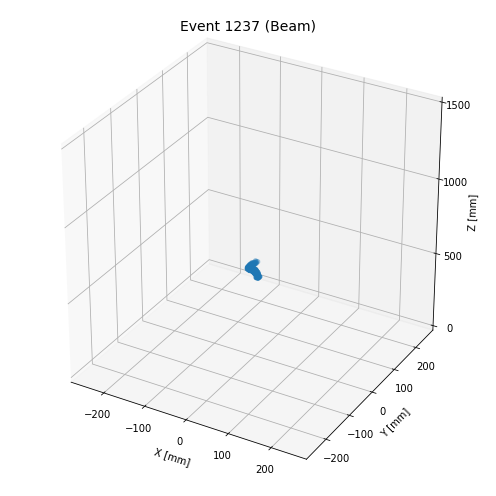

>>> Outliers:  1711
stdev(X)       :  5.235317634930183
Number of Pads :  247.0
FCP            :  8.50%


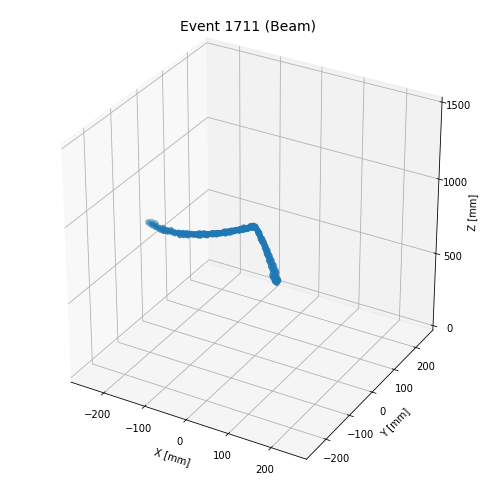

In [21]:
# Outliers Beam events characteristics
large_x_stdev = train_b_idx[StDevXPerEvent[train_b_idx]>3] # List of reaction events with stdev(X)>3
large_pads = train_b_idx[PadsPerEvent[train_b_idx]>100] # 
small_frac_close = train_b_idx[FracClosePtsPerEvent[train_b_idx]<0.4] # List of reaction event with FCP<0.4 
print("Outliers using different criteria:")
print("stdev(X) > 3 cm       :", np.sort(large_x_stdev))
print("Number of Pads > 100  :", np.sort(large_pads))
print("FCP < 0.4             :", np.sort(small_frac_close))

# Outliers that responde to (at least) one criterion 
outliers = np.union1d(np.union1d(large_x_stdev, large_pads),small_frac_close)
print("Outliers that satisfy at least one criterion:", outliers)
print("\n")

# Plotting Outliers
for i in range(len(outliers)):
    print(">>> Outliers: ", outliers[i])
    print("stdev(X)       : ", StDevXPerEvent[outliers[i]])
    print("Number of Pads : ", PadsPerEvent[outliers[i]])
    print("FCP            :  {:.2f}".format(FracClosePtsPerEvent[outliers[i]]*100) + "%")
    plot_3d_event(DataList,Labels,outliers[i])

### Design Matrix


We can see that these features we have extracted are meaningful in order to distinguish beam/reaction, and we gave an interpretation of the graphs obtained. The most meaningful features are used to create a design matrix (also called feature matrix). We call this xSimple, later on we may add other features, making the matrix more complex, and see if we obtain better results.



In [25]:
X = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    X[i][0] = MeanZPerEvent[i]
    X[i][1] = StDevXPerEvent[i]
    X[i][2] = FracClosePtsPerEvent[i]
    X[i][3] = SumAPerEvent[i]
    X[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
X_train =      X[train_idx][:]
X_val =        X[val_idx][:]
X_test =       X[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val =   Labels[val_idx]
Labels_test =  Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X_df= pd.DataFrame(X)
print("Design Matrix X:")
feature_names = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X_df.columns = feature_names
label_names = ['Beam','Reaction']
display(X_df)

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


### Scaling the data 
Scaling (or normalization) of the data
can improve the model performance quite significantly in some cases. Scikit-learn has a few different methods, of which the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) is used below. This scaler transforms each feature to have mean zero and unit variance. 
<a id='StandardScaler'></a>

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Using the standardscaler
X_train_stdsc = scaler.transform(X_train)
X_val_stdsc = scaler.transform(X_val)
X_test_stdsc = scaler.transform(X_test)

#  <span style="color:darkred">Machine Learning</span> 